In [1]:
import sys
sys.path.append('../') # remove once 
import dsp # is a python script that contains all the functions and code
import pandas as pd
import numpy as np

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Science Objective
To discover if there is a relationship between the high nighttime temperatures and yield. I plan to measure the number of nighttime hours over a high nighttime temperature threshold to see if there is a relationship with corn yield.  I believe there will be an inverse relationship between the number of high nighttime temperature hours and corn yield.

# Data
## Weather Station Data
I opted to use weather station temperature data for this project because of the number of observations available.  The weather station temperature data has multiple observations per hour.  The frequency of the data allows for more detailed and accurate analysis.  The large number of observations will allow me to capture the amount of high nighttime temperature hours more accurately. The weather station data begins in 2006.

In my experience weather station data does have some limitations. 

* The weather stations can produce low quality or inconsistent data. 

* The weather station is only measuring temperature at the location of the station. 

* Locations of the weather stations tend to be in urban areas (i.e. airports). 

I believe the benefits of having an abundance of sub-hourly data outweigh the potential risks.  To mitigate the risks of using weather data, I will select stations that I think have consistent and high-quality data.  

### Weather station data source
https://www.ncei.noaa.gov/maps/hourly/ 

### Weather Station Data Documentation
https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf
 
## USDA NASS county yield data
Yield is the amount of a crop produced per unit of land.  The higher the yield value generally mean that more crop was produced that year. The goal of every crop year is to increase crop production and one way to do that is increase yield and the another method is to increase harvested acres. The USDA NASS county yield data units in bushel per acre The yield comes from the USDA NASS Quick Stats website.  The USDA stopped publishing county yield data in 2023. The analysis will use yield data from 2006 to 2023.

### USDA NASS county yield data source
https://quickstats.nass.usda.gov

## United States county shapefile
I downloaded a U.S. County shapefile to display the county of the weather station on a map.

### United States county shapefile source
https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip

## United States county FIPS code list
I needed the U.S. county FIPS code list to have a common key between the yield data the county shapefile.

### County FIPS code list source
https://www2.census.gov/geo/docs/reference/codes2020/national_county2020.txt

# Dictionary of station IDs and station names
The stations were selected at random with an emphasis on data completeness. 

In [2]:
# dictonary of stations IDs and locations
stn_dict = {72217104889: 'PONTIAC MUNICIPAL AIRPORT, IL US',
            72545704904: 'ALGONA MUNICIPAL AIRPORT, IA US',
            72547804920: 'WEBSTER CITY MUNICIPAL AIRPORT, IA US',
            72649804925: 'FAIRFIELD MUNICIPAL AIRPORT, IA US',
            72208204876: 'FREEPORT ALBERTUS AIRPORT, IL US',
            72546194988: 'MARSHALLTOWN MUNICIPAL AIRPORT, IA US',
            72548404942: 'LE MARS MUNICIPAL AIRPORT, IA US',
            74465363814: 'SPARTA COMMUNITY HUNTER FIELD AIRPORT, IL US',
            72549504975: 'SHELDON MUNICIPAL AIRPORT, IA US'}

# Loading the weather station data
* Loading in data from zipfile.
* Deleting csv after loading into Python to save space.
* Loading in data from FAIRFIELD MUNICIPAL AIRPORT, IA US.

In [3]:
stn_df = dsp.load_func_zip(72649804925,path='data')

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (20,23,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


In [4]:
# Dropping unneeded columns
stn_df = dsp.drop_func(stn_df)
stn_df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,TMP
0,72649804925,2006-01-01T00:15:00,4,41.05306,-91.97889,243.5,"FAIRFIELD MUNICIPAL AIRPORT, IA US","-0010,1"
1,72649804925,2006-01-01T00:35:00,4,41.05306,-91.97889,243.5,"FAIRFIELD MUNICIPAL AIRPORT, IA US","-0010,1"
2,72649804925,2006-01-01T00:55:00,7,41.05306,-91.97889,243.5,"FAIRFIELD MUNICIPAL AIRPORT, IA US","-0010,C"
3,72649804925,2006-01-01T01:15:00,4,41.05306,-91.97889,243.5,"FAIRFIELD MUNICIPAL AIRPORT, IA US","-0010,1"
4,72649804925,2006-01-01T01:35:00,4,41.05306,-91.97889,243.5,"FAIRFIELD MUNICIPAL AIRPORT, IA US","-0010,1"


# Getting County Information
* Performing a spatial join between the U.S. County shapefile and weather stations' latitude and longitude location.
* Need the county FIPS code to join weather station data with USDA NASS yield data.

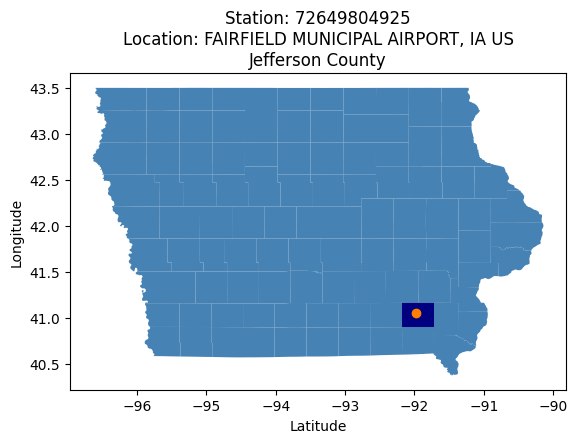

In [5]:
cnty_fip,cnty_name = dsp.get_county_func(stn_df,path='data',plot=True)

In [6]:
# checking for NAs
np.sum(stn_df.isna(),axis=0)

STATION      0
DATE         0
SOURCE       0
LATITUDE     0
LONGITUDE    0
ELEVATION    0
NAME         0
TMP          0
dtype: int64

# Cleaning up the weather station data
* The weather station data did not have NAs but it did have quality control code.
* Kept all data with following control codes ['1','5','C].
* To get the temperature data, I split the TMP column from the QC code and divided that number by 10 to get the temperature value.
* The data approximately follows a normal distribution.

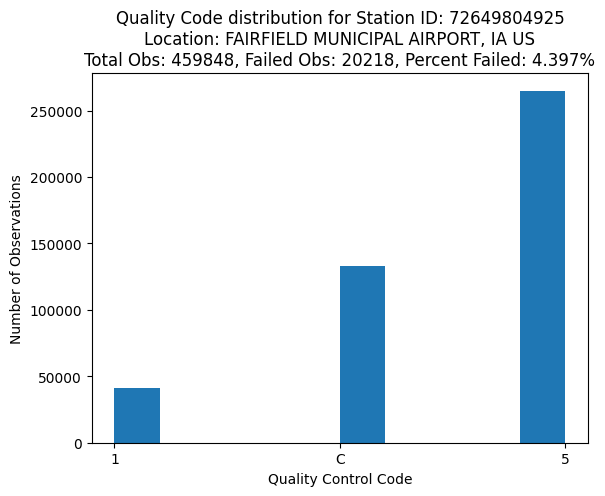

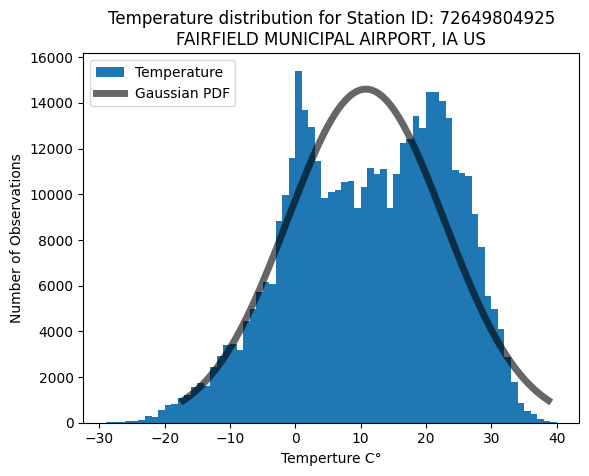

In [7]:
stn_df = dsp.temp_cln_func(stn_df,cnty_name,plot=True)

# Clean and format the weather station datetime data
* Converted datetime to CST timezone from UTC timezone.
* Calculated the average observations per hour.
* Grouped observations by year.
* The box and whisker plot shows that the data is consistent from year to year.  The plots themselves have long whiskers compared to the boxes and the few outliers. 

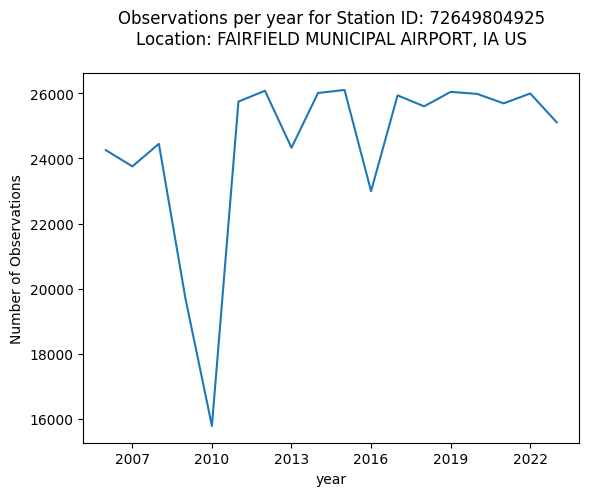

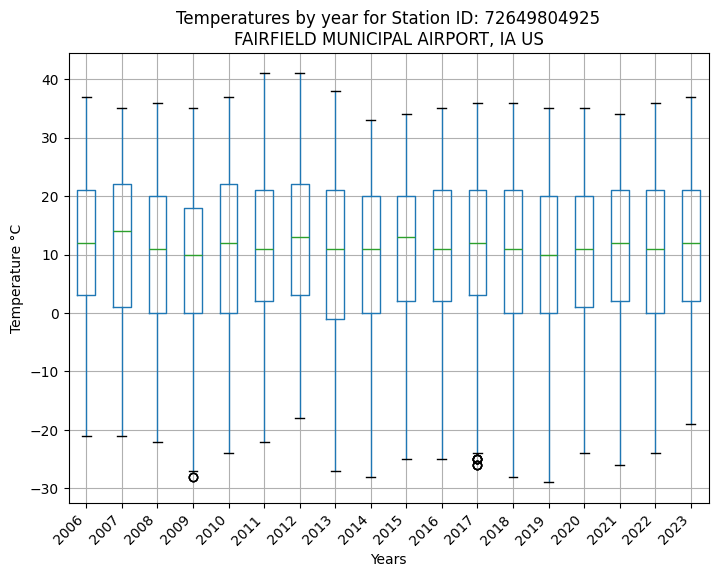

Avg Obs per hour:  3


In [8]:
stn_df,obs_per_hour,grp_df = dsp.date_cln_func(stn_df,cnty_name,plot=True)

# Date and time filtering of the weather station data
I filtered for the dates where the majority of kernal development takes place and filtered for nighttime hours.
* For the start date of June 15th, with the assumption of planting beginning on April 1st,  kernel development begins approximately 60-70 days after emergence. Emergence happens 5-10 days after planting and may take longer depending on soil temperature.
* August 15th was selected as the end date to capture the kernel development period for areas where planting may occur later in the spring.
* The date and time filtered temperature data fits almost perfectly to a normal distribution.
* The box and whisker plots show some variability by year and more outliers than the unfiltered data.  This agrees with my hypothesis because yield varies by year.  If nighttime temperatures affect yield, they need to show some variation year to year also.

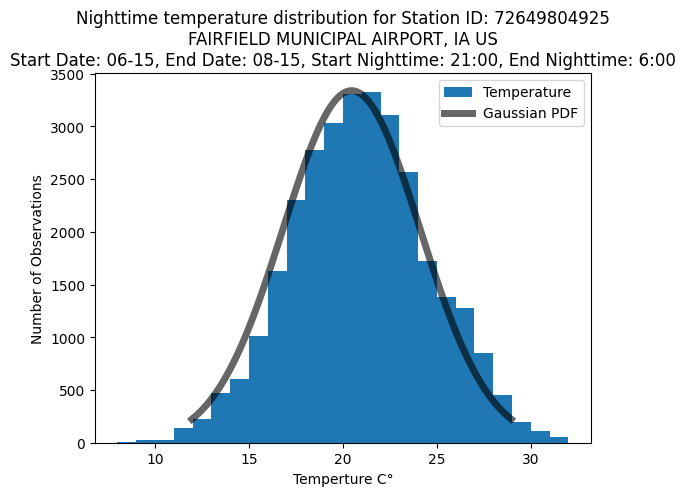

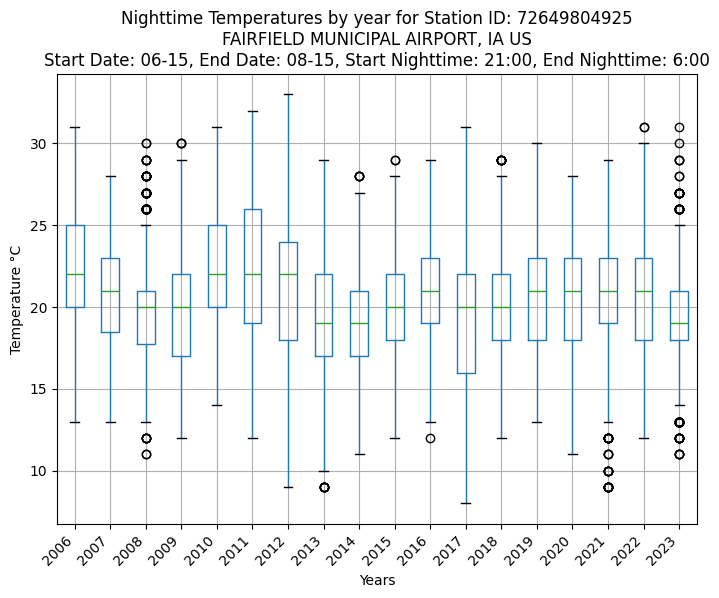

In [9]:
start_date = '06-15'
end_date = '08-15'
start_time = 21 # 9:00PM
end_time = 6 # 6:00AM
nite_df, disp_df = dsp.night_time_func(stn_df,cnty_name,start_date, end_date, start_time,end_time,plot=True)

# Filtering weather station data for tempertures above 27°C
* 27°C was chosen because nighttime temperatures in the range of 80°F and above can be very detrimental to corn yield.
* I selected a temperature on the low end of the range to maximize the number of observations for the analysis.
* The box and whisker plots show a lot of variability in maximum temperature values year to year. 

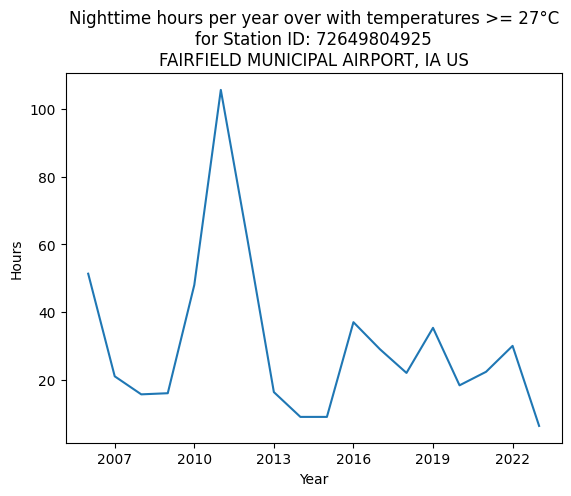

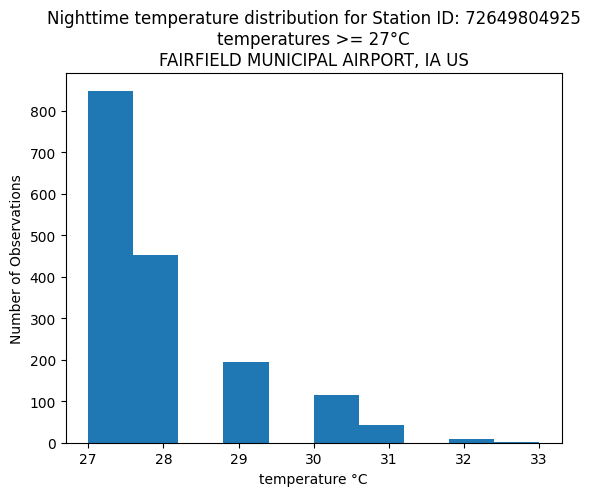

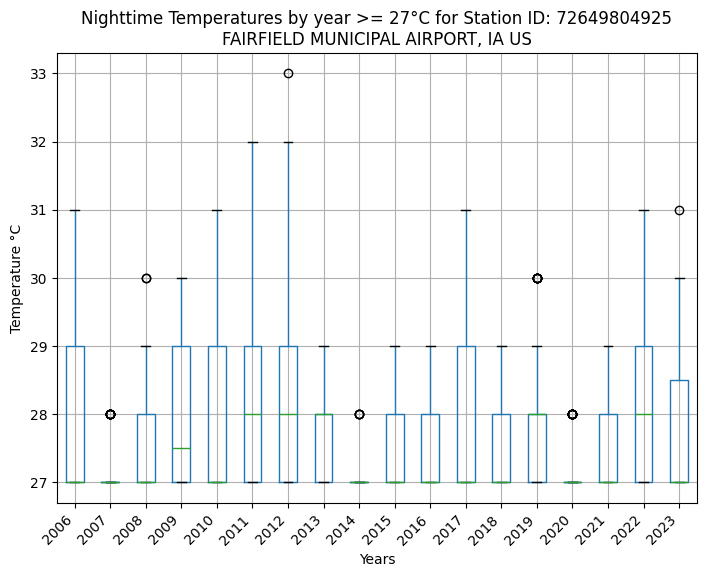

In [10]:
temp = 27
nite_hot_df, nite_hot_grp_df = dsp.get_temp_count(nite_df,cnty_name,obs_per_hour,
                                                  start_date,end_date,start_time,end_time,temp,plot=True)

In [11]:
print("number of obs: {}".format(len(nite_hot_df)))

number of obs: 1662


# Loading the USDA NASS county corn yield data
* Trend yield refers to the fact that average crop yields increase through time due to better farming practices and increases in technology.
* The county yield history contains a lot of variability through time.

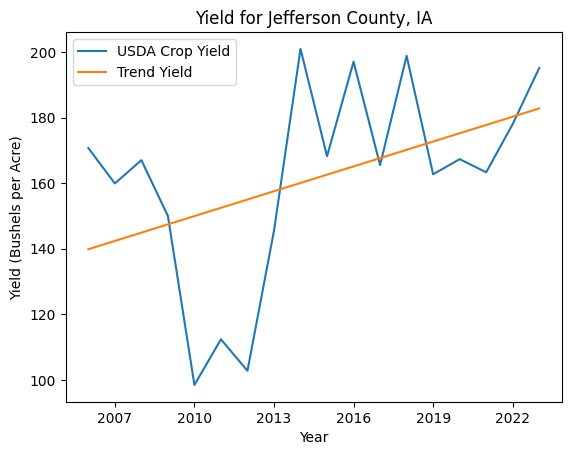

In [12]:
yld_df = dsp.load_nass_yld_func(cnty_fip,cnty_name,path='data',plot=True)

# Merging the hot nighttime temperature data and and USDA NASS yield data
* Preparing the data for the regression analysis.
* Dropping rows with NA if they exist.
* The data is available from 2006 to 2023.
* The weather station data is from 2006 onward, and the county yield data goes until 2023. 

In [13]:
hr_yld_data = pd.merge(nite_hot_grp_df,yld_df,how='left',on='year').dropna()
hr_yld_data

,year,obs_num,hours,Value
0,2006,154,51.333333,170.7
1,2007,63,21.000000,159.9
2,2008,47,15.666667,167.0
3,2009,48,16.000000,150.0
4,2010,144,48.000000,98.5
5,2011,317,105.666667,112.4
6,2012,185,61.666667,102.8
7,2013,49,16.333333,145.5
8,2014,27,9.000000,200.9
9,2015,27,9.000000,168.2


# Running the regression analysis
* Running the linear regression to determine the relationship between high nighttime temperatures and corn yield.
* Year 2012 is highlighted because that was a historic year with extreme drought and heat.
* The analysis results in a R² of .41.  This confirms that some of the variance in yield can be attributted to high nighttime tempertures.

R2:  0.41


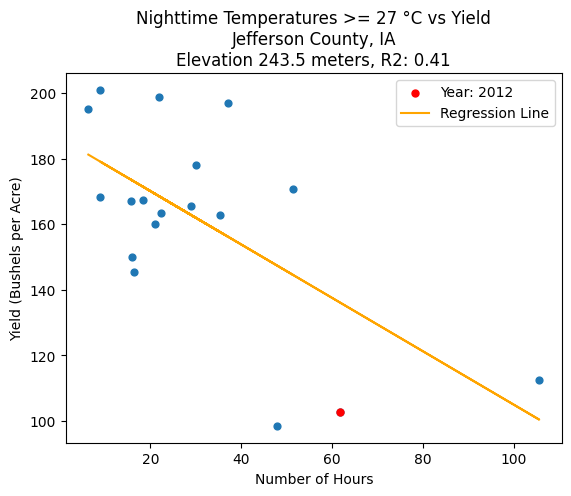

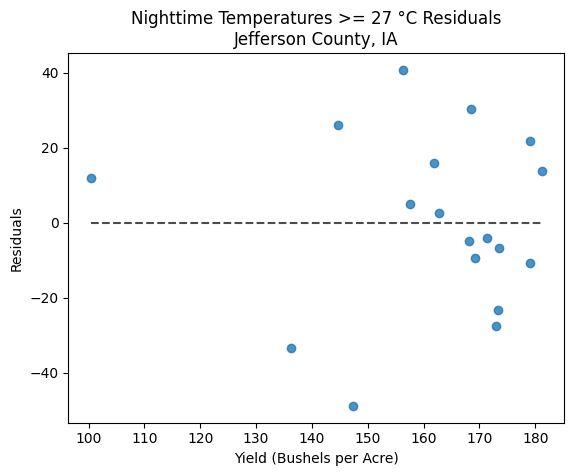

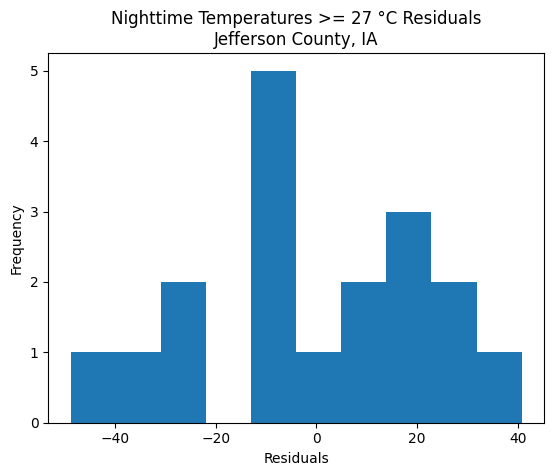

In [14]:
elev = nite_hot_df['ELEVATION'].unique()[0]
r2 = dsp.regression_func(hr_yld_data,cnty_name,temp,elev,plot=True,save=False)

# P- value
* A p-value of 0.068 is marginally significant and suggests the nighttime temperatures could influence yield, but not strong enough to be statistically significant.
* The analysis is only using one variable, and crop devlopment is a complex biological process and cannot be captured in one variable.

In [15]:
print(dsp.get_pvalue_func(hr_yld_data))

0.06846453891552554


# Try to improve the relationship
With only 18 years of data, I am constrained on what I able do with feature engineering, and I am hesitant to remove any data points.  I can increase the number of observations per year by lowering the temperature threshold to 26°C.  With the increase in observations, the analysis should reflect a wider range of crop conditions.  My only concern with lowering the temperature threshold is that it might increase the noise in the data and obscure any signal from the high nighttime temperatures.

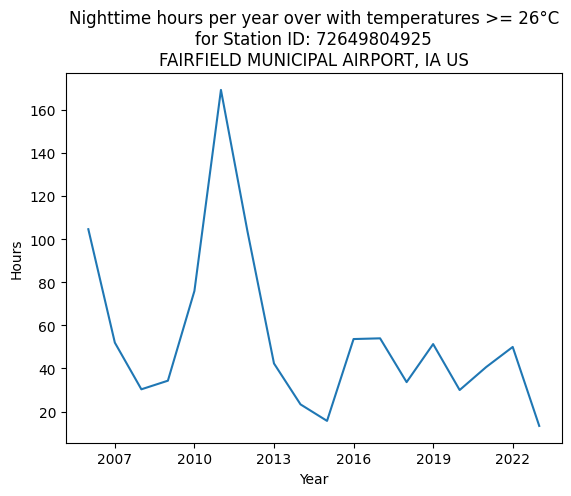

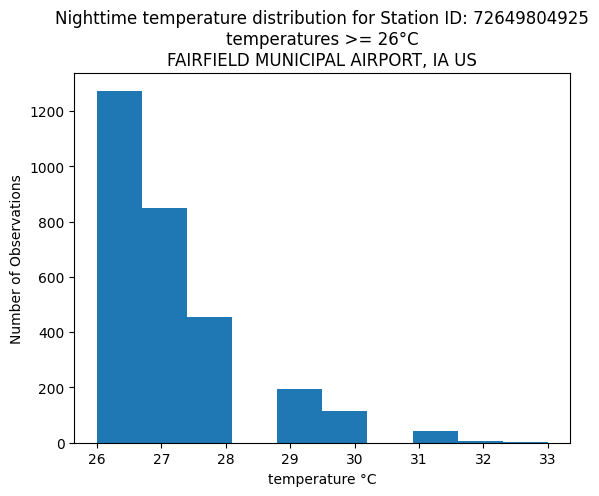

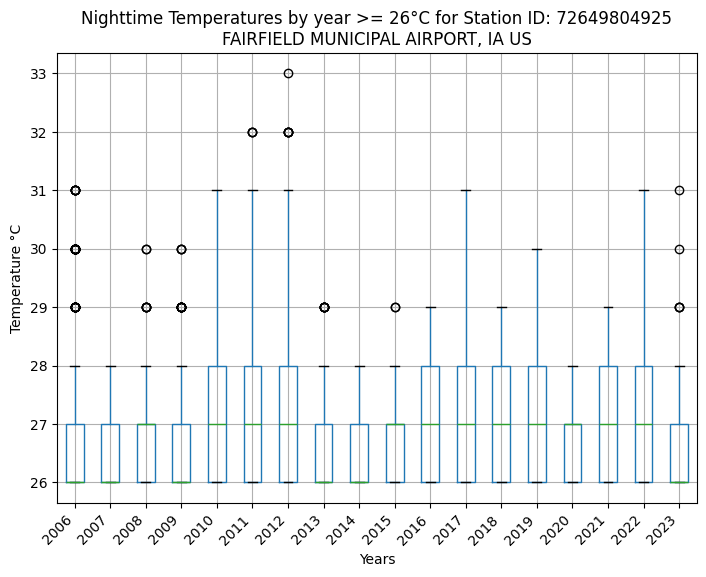

In [16]:
# filtering by 26 C which around 79 F
temp = 26
nite_hot_df2, nite_hot_grp_df2 = dsp.get_temp_count(nite_df,cnty_name,obs_per_hour,
                                                  start_date,end_date,start_time,end_time,temp,plot=True)

In [17]:
# lower the threshold to 26 C gives me 2935 observations compared to 27 C which yielded 1662 observations
print("number of obs: {}".format(len(nite_hot_df2)))

number of obs: 2935


In [18]:
hr_yld_data2 = pd.merge(nite_hot_grp_df2,yld_df,how='left',on='year').dropna()
hr_yld_data2

,year,obs_num,hours,Value
0,2006,314,104.666667,170.7
1,2007,156,52.000000,159.9
2,2008,91,30.333333,167.0
3,2009,103,34.333333,150.0
4,2010,228,76.000000,98.5
5,2011,508,169.333333,112.4
6,2012,311,103.666667,102.8
7,2013,127,42.333333,145.5
8,2014,70,23.333333,200.9
9,2015,47,15.666667,168.2


R2:  0.422


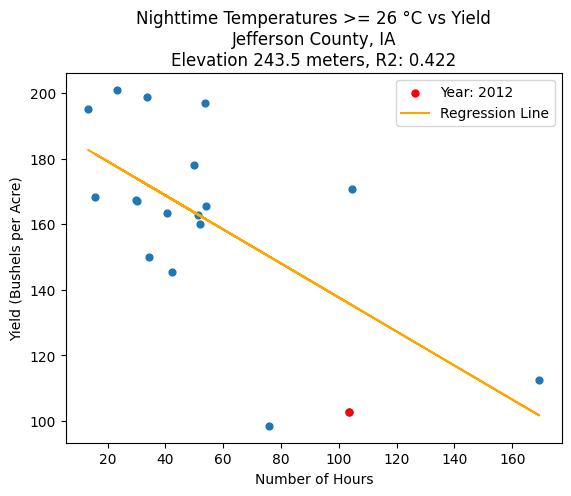

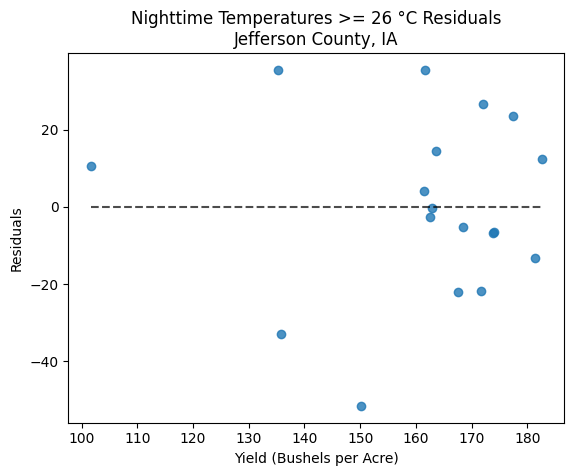

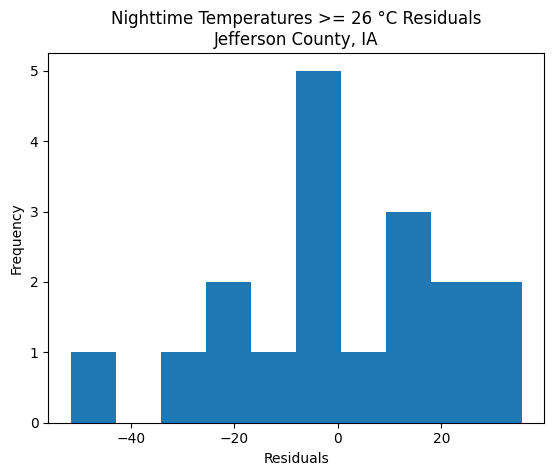

In [19]:
elev = nite_hot_df2['ELEVATION'].unique()[0]
r2 = dsp.regression_func(hr_yld_data2,cnty_name,temp,elev,plot=True,save=False)

In [20]:
dsp.get_pvalue_func(hr_yld_data2)

0.06846453891552554

# Results of lowering the temperature threshold to 26°C
* Increase of weather station temperature observations from 1662 to 2935
* A slight increase of R² from .41 to .42

# Data Analysis
I am using a linear regression to see if there is a relationship between high nighttime temperatures and corn yield. I chose to perform a linear regression analysis because linear regressions can quantify a relationship between variables.  I am using R² as the primary metric because I want to see if any variance in yield can be attributed to high nighttime temperatures.

For my analysis of nighttime temperatures and yield for Jefferson County, Iowa, the analysis returned a R² of .422.  The residual plot has no discernible pattern, except the majority of points are located on the right side of the plot.  The points seem to be equally distributed between positive and negative values.  The p-value for the regression was .068.

High nighttime temperatures are likely to affect the yield of a corn crop for Jefferson County, Iowa.  With a p-value of .068 and the R² of .422, there is enough evidence that high nighttime temperatures can affect yield. Plant development is a complex biological process and having one variable with a R² of .422 shows that high nighttime temperatures are likely to influence crop yield.


# Running analysis on all weather stations
* Running the analysis on all stations.
* Using 26°C because of the slight increase of R² from the previous analysis.
* The goal is see if the analysis can produce similar results in different counties in Illinois and Iowa.

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (21,26,34,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


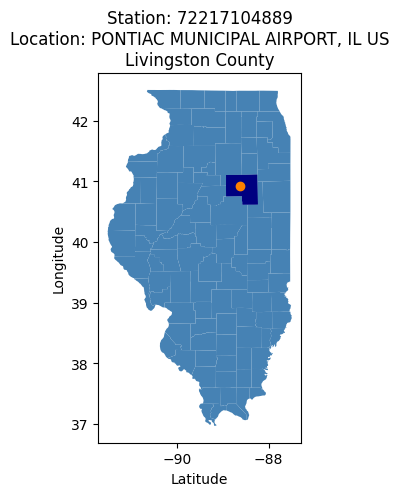

Avg Obs per hour:  3
R2:  0.524


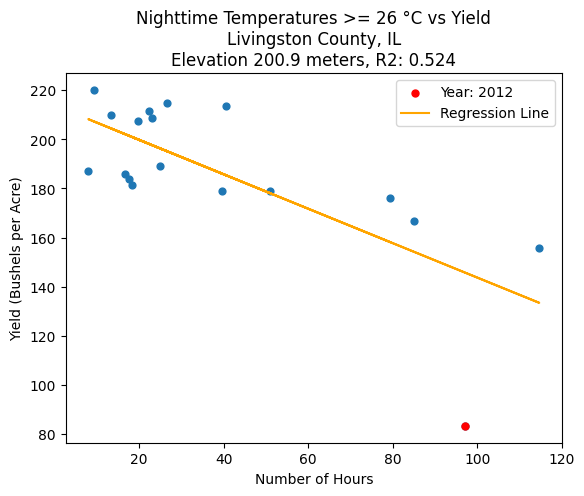

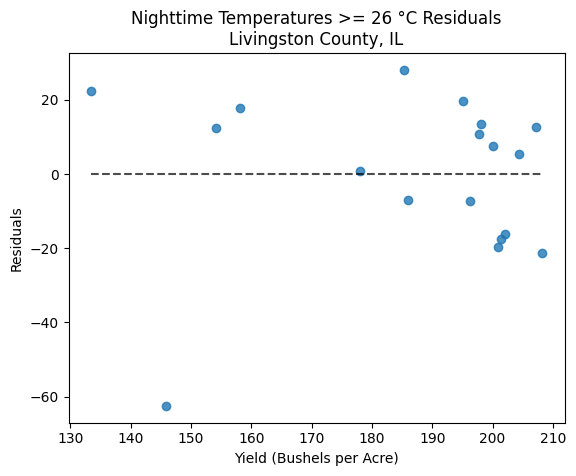

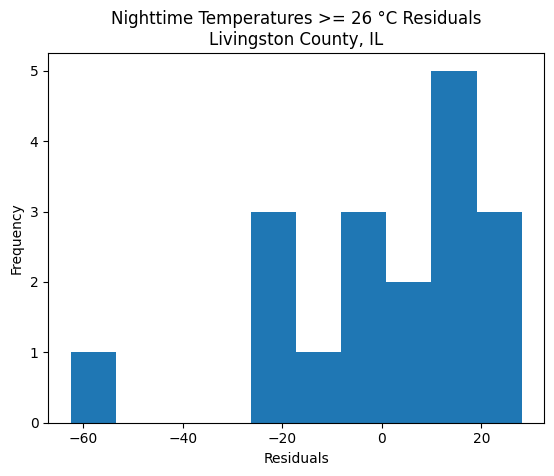

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (20,21,24,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


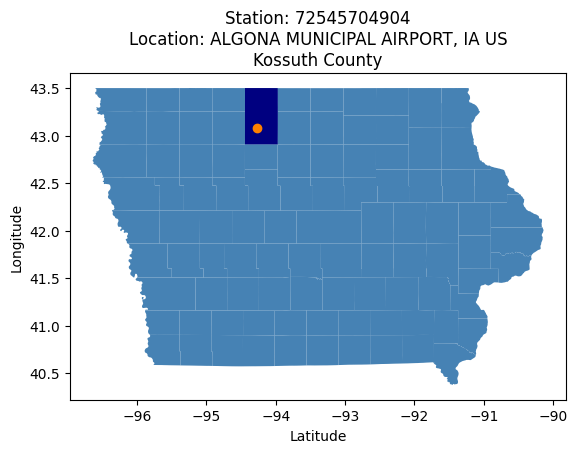

Avg Obs per hour:  3
R2:  0.022


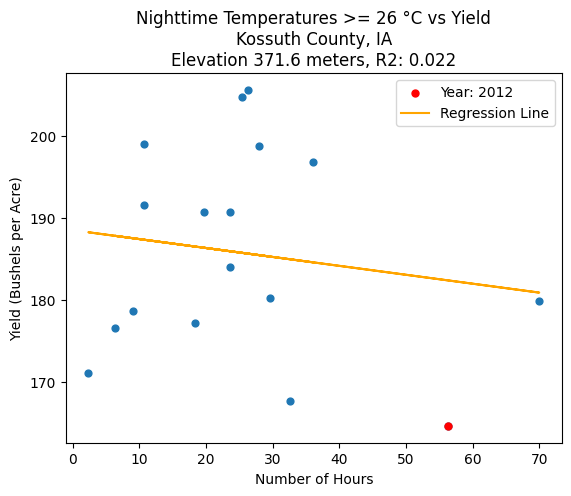

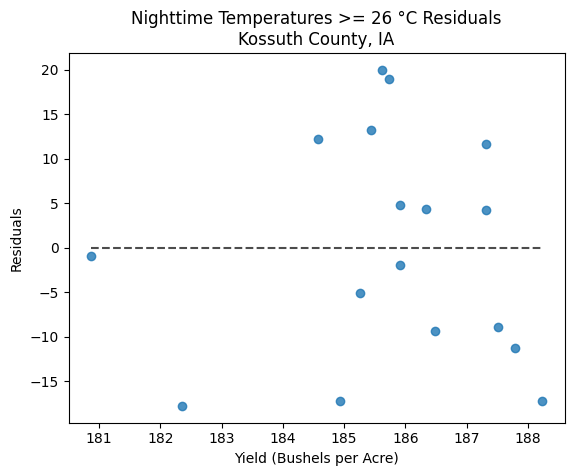

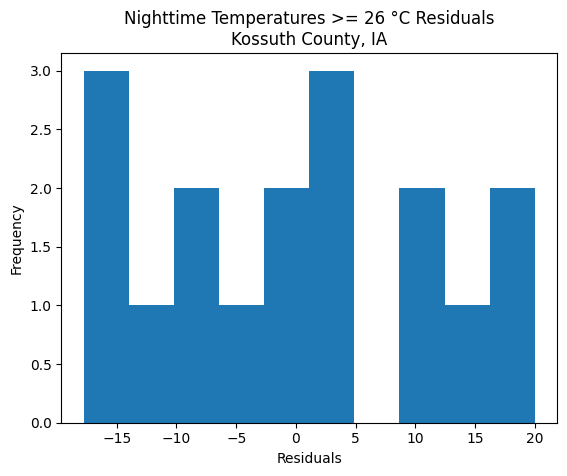

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (20,21,24,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


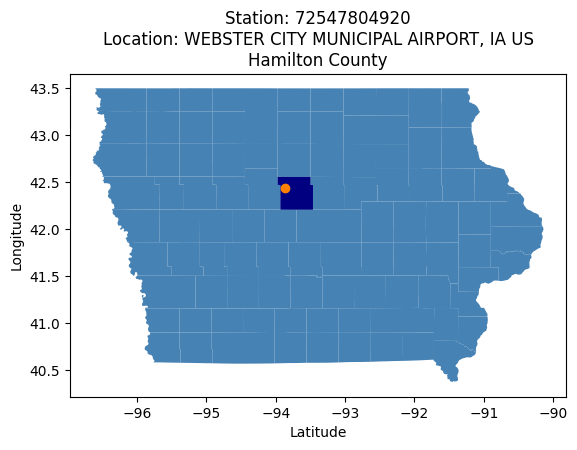

Avg Obs per hour:  3
R2:  0.1


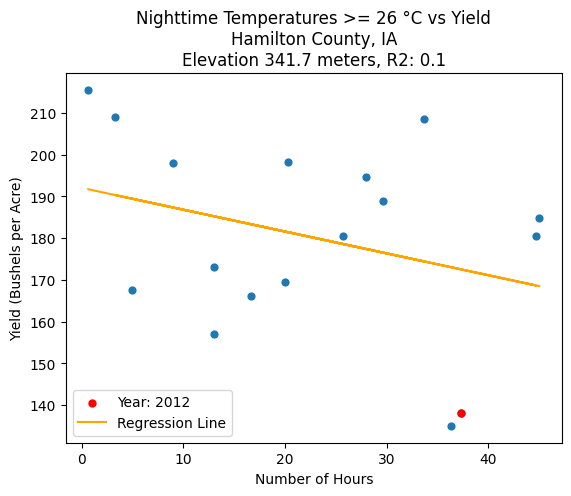

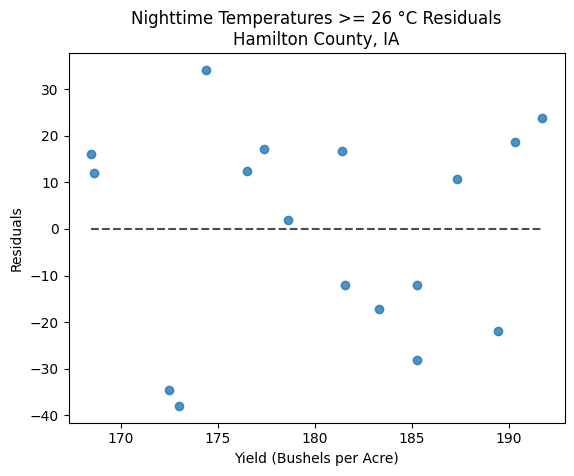

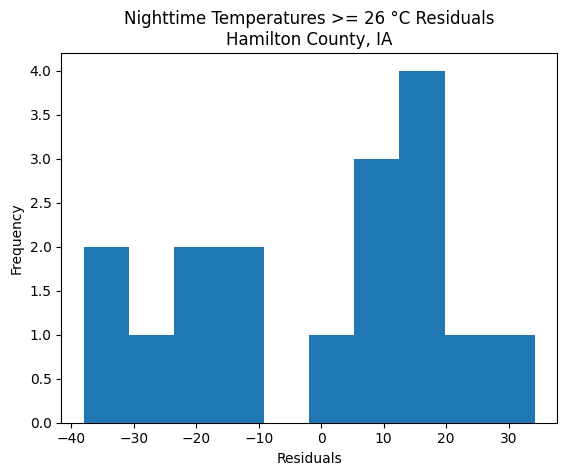

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (20,23,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


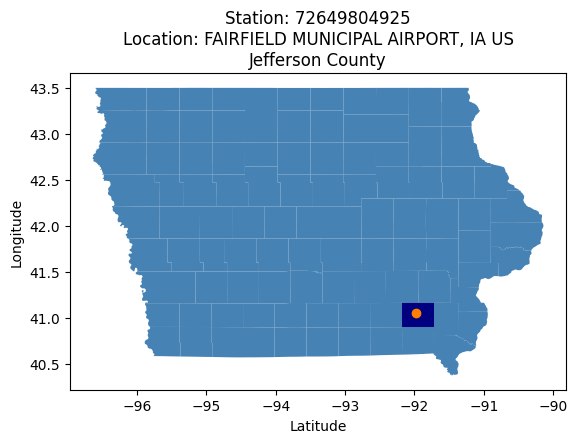

Avg Obs per hour:  3
R2:  0.422


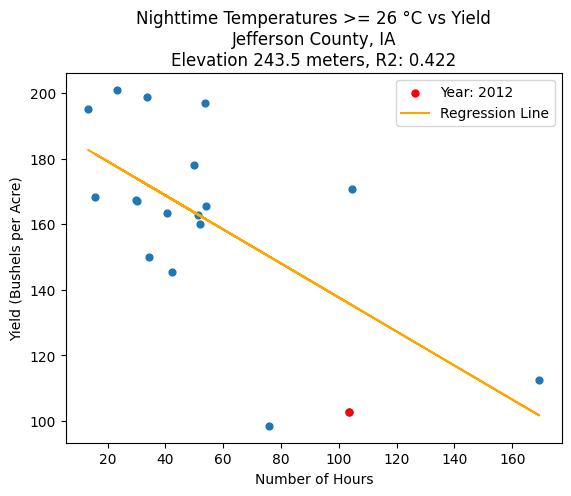

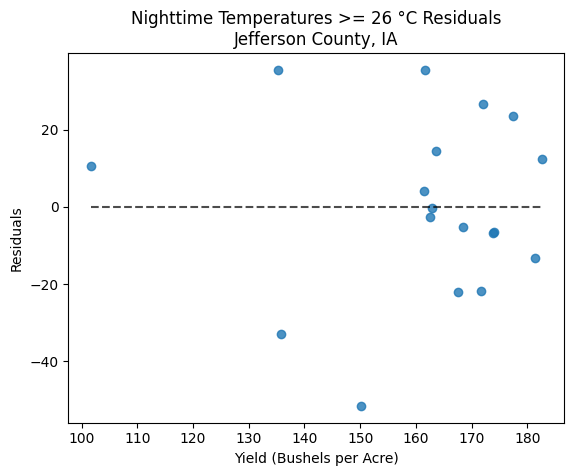

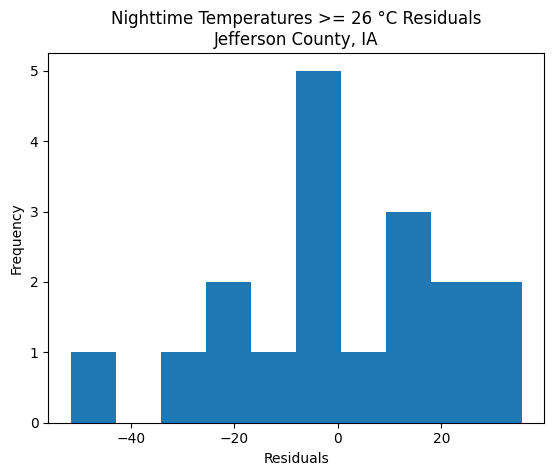

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (20,21,26,40,41,42,43,44,45,46,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


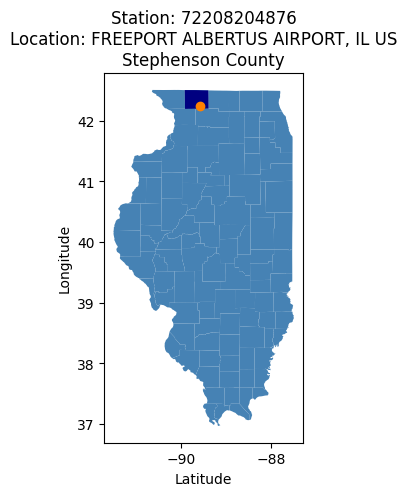

Avg Obs per hour:  3
R2:  0.229


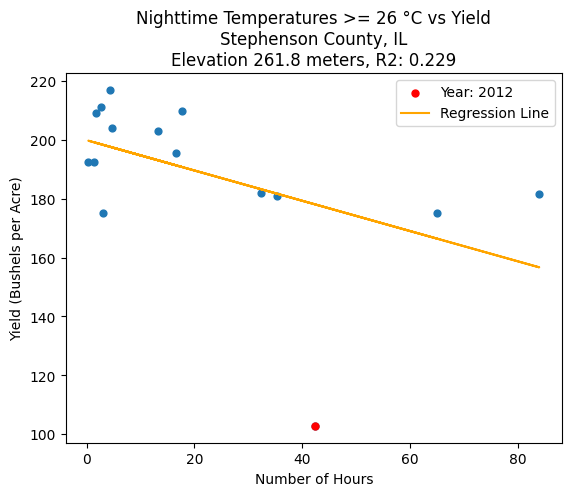

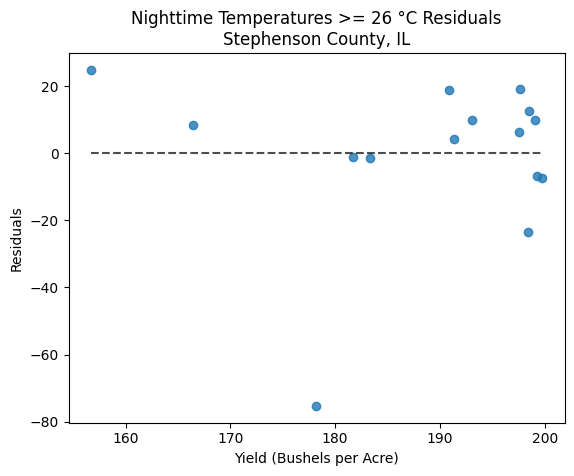

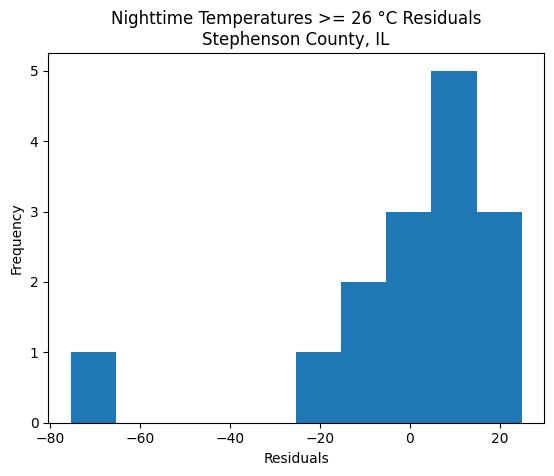

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (2,38,39,46,48,49,50,52,53,55,56,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


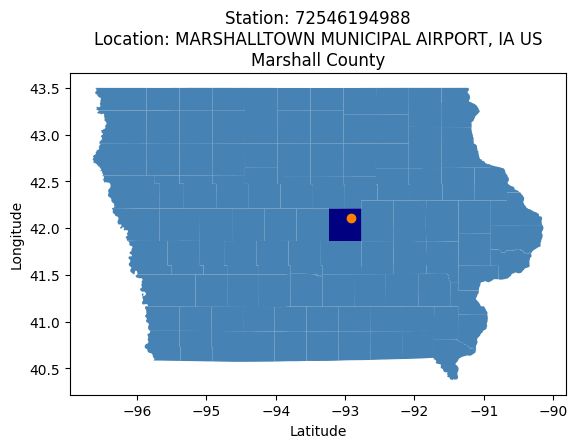

Avg Obs per hour:  1
R2:  0.225


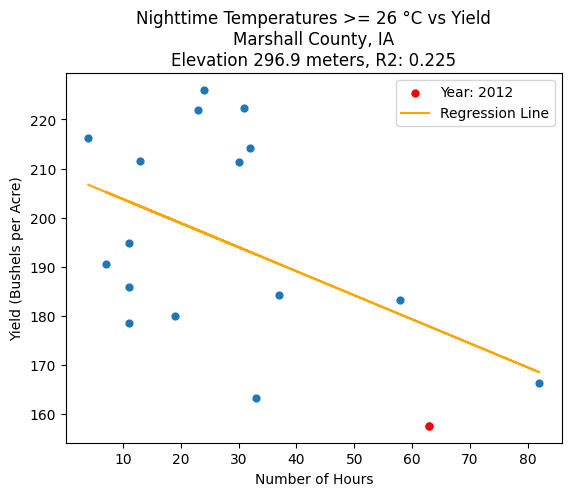

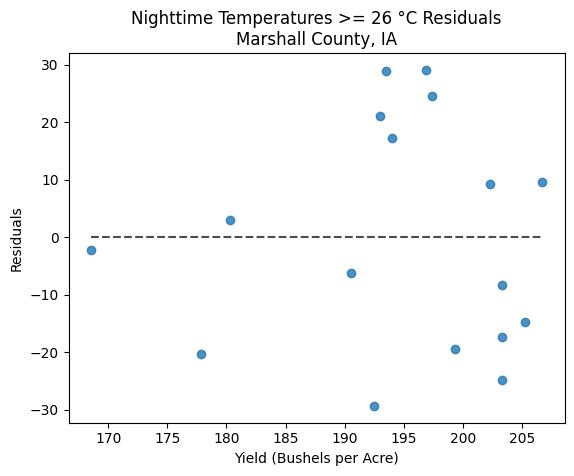

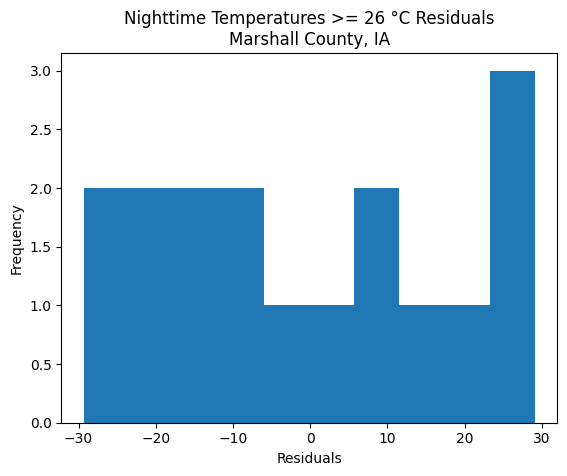

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (23,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


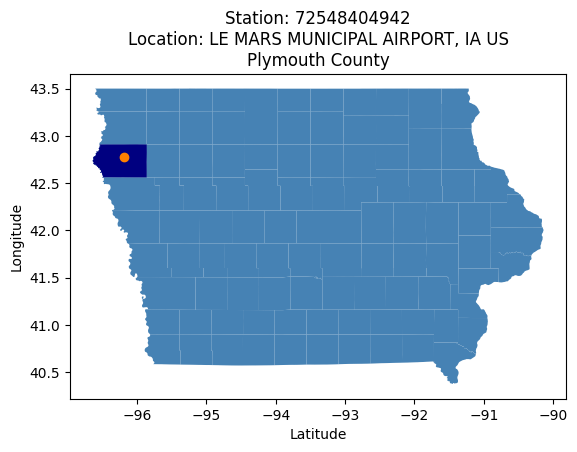

Avg Obs per hour:  3
R2:  0.282


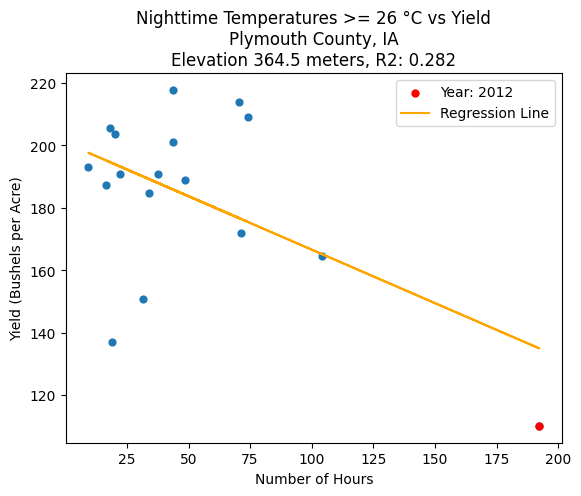

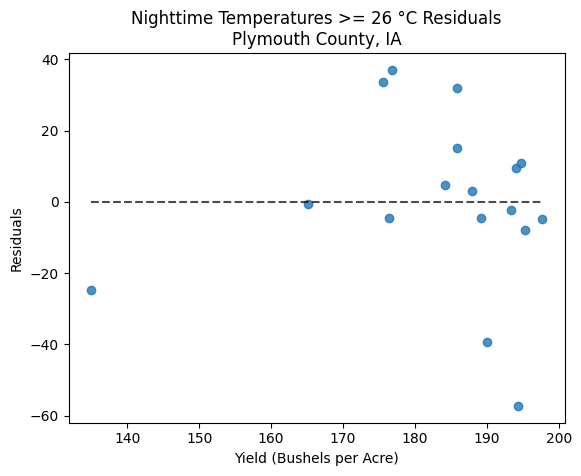

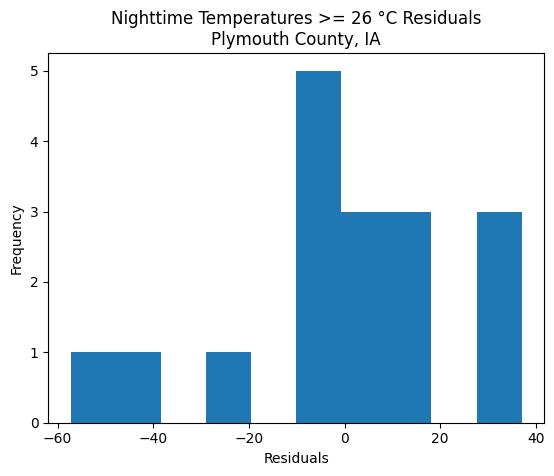

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (21,22,24,26,27,36,41,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


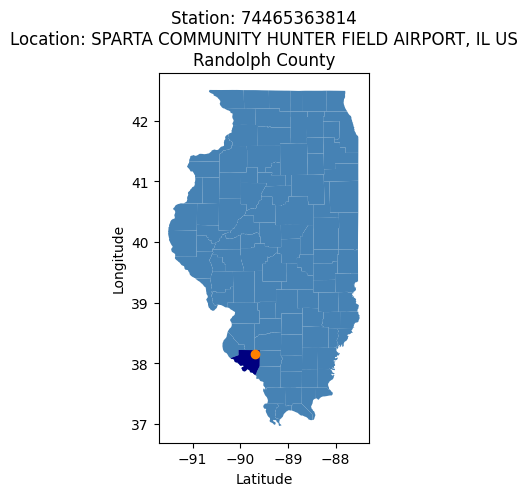

Avg Obs per hour:  3
R2:  0.66


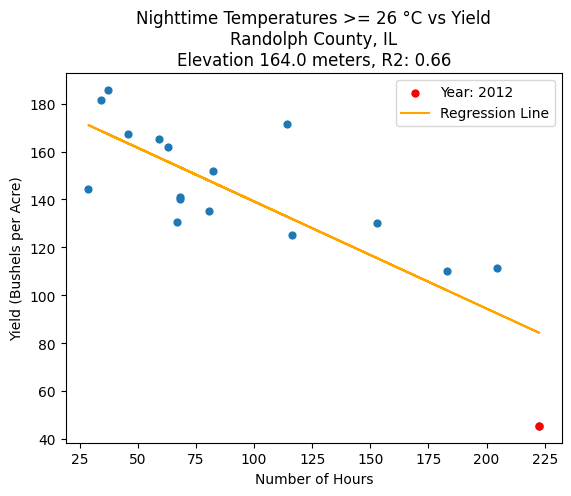

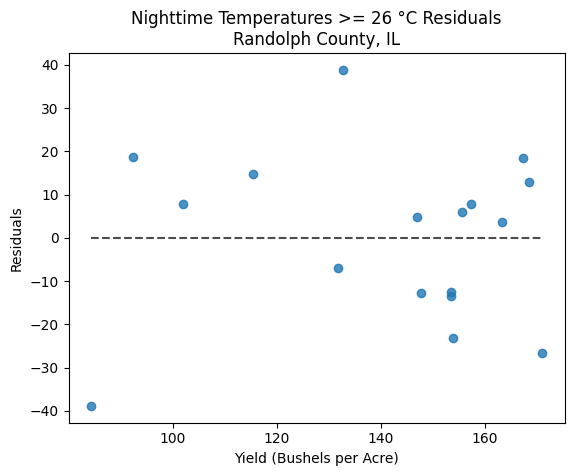

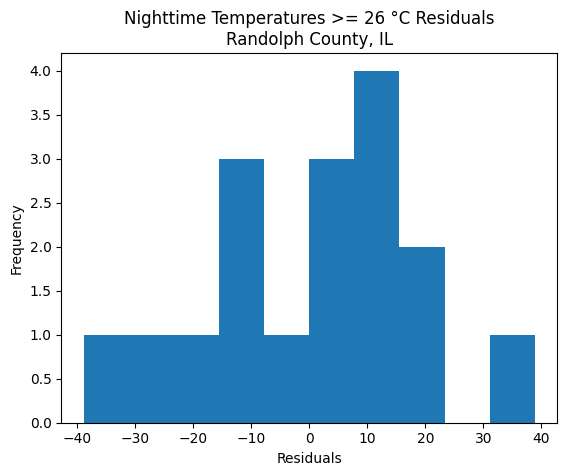

/home/ptrierweiler/MEGA/ATH_517/ath_517_project/trierweiler_project/../dsp.py:60: DtypeWarning: Columns (21,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  out_df = pd.read_csv(in_csv)


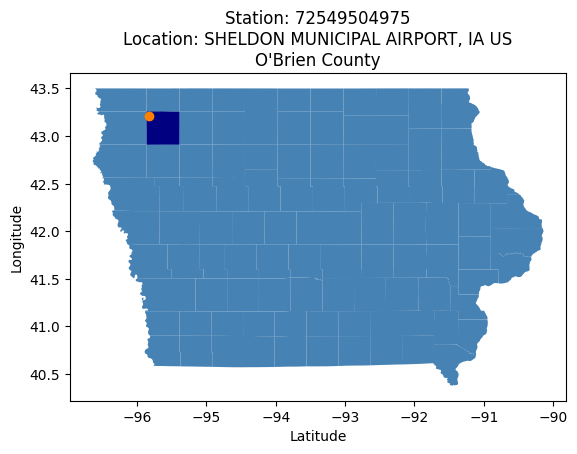

Avg Obs per hour:  3
R2:  0.135


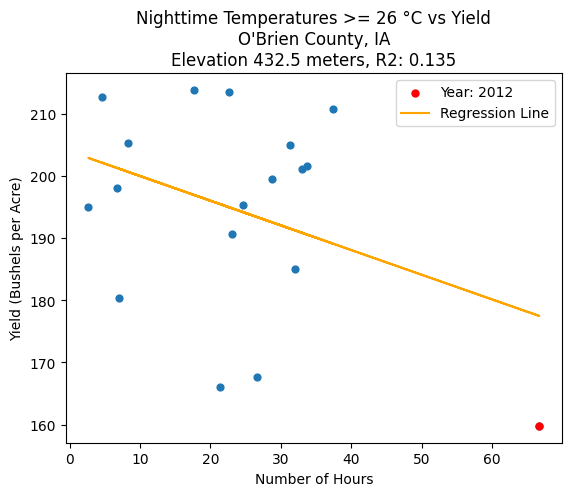

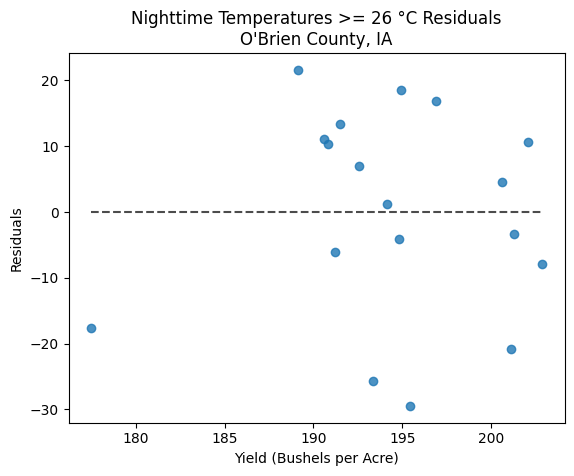

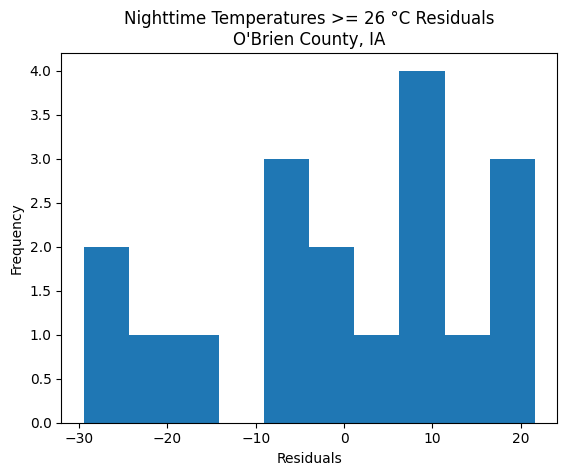

In [21]:
start_date = '06-15'
end_date = '08-15'
start_time = 21 # 9:00PM
end_time = 6 # 6:00AM
temp = 26
out_df = pd.DataFrame()
for i in stn_dict.keys():
    stn_id,r2,elev,lat,lon = dsp.super_func(i,start_date,end_date,start_time,end_time,temp,plot=False)
    name = stn_dict[i]
    st = name.split(',')[1].strip().split(' ')[0]
    t = {'stn_df': [stn_id],'r2': [r2],'elev':[elev],'state':[st],'lat':[lat],'lon':[lon]}
    out_df = pd.concat([out_df,pd.DataFrame(t)])

# Map of Stations with Elevation

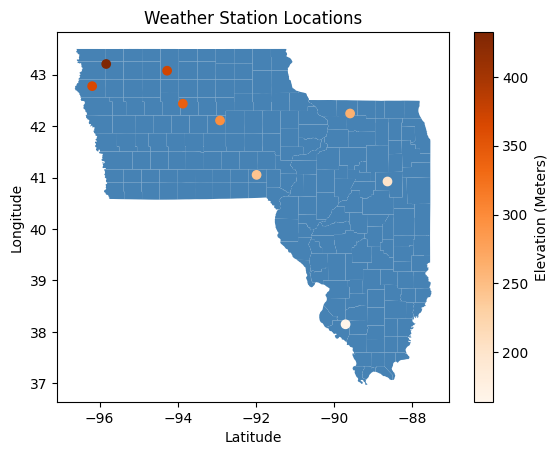

In [22]:
dsp.station_map(out_df)

In [23]:
out_df

,stn_df,r2,elev,state,lat,lon
0,72217104889,0.524,200.9,IL,40.92440,-88.62390
0,72545704904,0.022,371.6,IA,43.07778,-94.27194
0,72547804920,0.100,341.7,IA,42.43639,-93.86861
0,72649804925,0.422,243.5,IA,41.05306,-91.97889
0,72208204876,0.229,261.8,IL,42.24611,-89.58222
0,72546194988,0.225,296.9,IA,42.11056,-92.91611
0,72548404942,0.282,364.5,IA,42.77778,-96.19361
0,74465363814,0.660,164.0,IL,38.14889,-89.69861
0,72549504975,0.135,432.5,IA,43.20833,-95.83333


In [24]:
out_df[['r2']].describe()

,r2
count,9.000000
mean,0.288778
std,0.208874
min,0.022000
25%,0.135000
50%,0.229000
75%,0.422000
max,0.660000


0.747


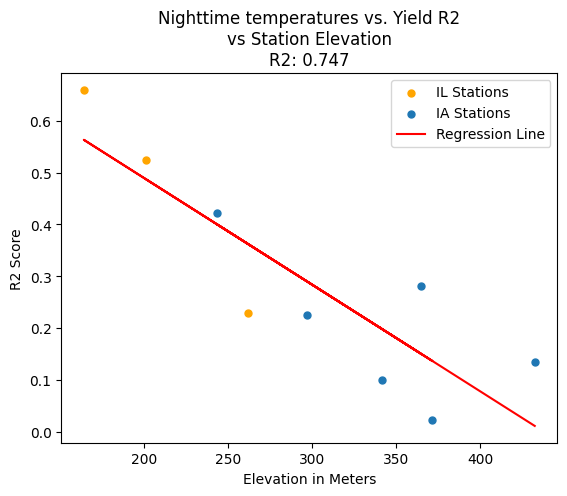

In [25]:
dsp.total_stn_reg_func(out_df)

# P-value

In [ ]:
dsp.get_pvalue_tot_func(out_df)

# Data analysis for all counties
I functionalized my analysis so I could automate the exploratory data analysis and data  processing steps.  I created a function called super_func that runs all the EDA and data processing steps in sequence. 

Performing an analysis on all counties produces a mixed bag of results with a range of R² values between .02 and .66.  This was very troubling for my hypothesis.  I believe Iowa and Illinois do not differ significantly in climate.  The only noticeable difference I could find was that counties with weather stations with lower elevations seem to have a higher R² than the counties with higher elevations. 

I did a scatter plot and a regression analysis using elevations and R² scores.  The results were very surprising.  The analysis using elevation and R² scores produced an R² of .747 and a p-value of .0026.  There is an inverse relationship with elevation and R². After running the analysis on multiple counties, I think the conclusion is that high nighttime temperatures have a more pronouced effect in counties in lower elevations.

My best guess at why I am getting different results for different elevations is that there are some other variables that might be negating any negative impact of high nighttime temperatures on corn yield. 

# Future Work
* Run additional analysis that finds the variables that might negate the detrimental effects of high nighttime temperatures at higher elevations.
* Run analysis on overall nighttime temperatures to see if there is an optimal temperature range for corn yield.
* Narrowing the analysis to more align with year by year planting dates.  Planting dates can change from year to year based on weather conditions.
* Using a source with a longer weather station data history.

# Challenges